In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)



In [2]:
DATA_DIR = Path("../data")
COUNTRY_FILES = {
    "Benin": DATA_DIR / "benin-malanville_clean.csv",
    "Sierra Leone": DATA_DIR / "sierraleone-bumbuna_clean.csv",
    "Togo": DATA_DIR / "togo_clean.csv",
}

# Load cleaned datasets
country_dfs = {}
for country, path in COUNTRY_FILES.items():
    if not path.exists():
        raise FileNotFoundError(f"Missing dataset for {country}: {path}")
    country_dfs[country] = pd.read_csv(path, parse_dates=["Timestamp"])

# Quick sanity check
{k: df.shape for k, df in country_dfs.items()}



{'Benin': (525600, 19), 'Sierra Leone': (525600, 19), 'Togo': (525600, 19)}

In [3]:
METRICS = ["GHI", "DNI", "DHI"]

# Build tidy dataframe for easier plotting/analysis
records = []
for country, df in country_dfs.items():
    subset = df[METRICS].copy()
    subset["Country"] = country
    records.append(subset)

tidy_df = pd.concat(records, ignore_index=True)

summary_table = (
    tidy_df.melt(id_vars="Country", value_vars=METRICS, var_name="Metric", value_name="Value")
    .groupby(["Country", "Metric"])["Value"]
    .agg(mean="mean", median="median", std="std")
    .reset_index()
)

summary_table



,Country,Metric,mean,median,std
0,Benin,DHI,116.199911,2.5,155.737004
1,Benin,DNI,151.195803,0.0,250.762744
2,Benin,GHI,230.525992,2.1,322.441047
3,Sierra Leone,DHI,113.465147,-0.1,158.112828
4,Sierra Leone,DNI,115.675784,-0.1,216.415753
5,Sierra Leone,GHI,201.612506,0.3,297.381491
6,Togo,DHI,116.199911,2.5,155.737004
7,Togo,DNI,151.195803,0.0,250.762744
8,Togo,GHI,230.525992,2.1,322.441047


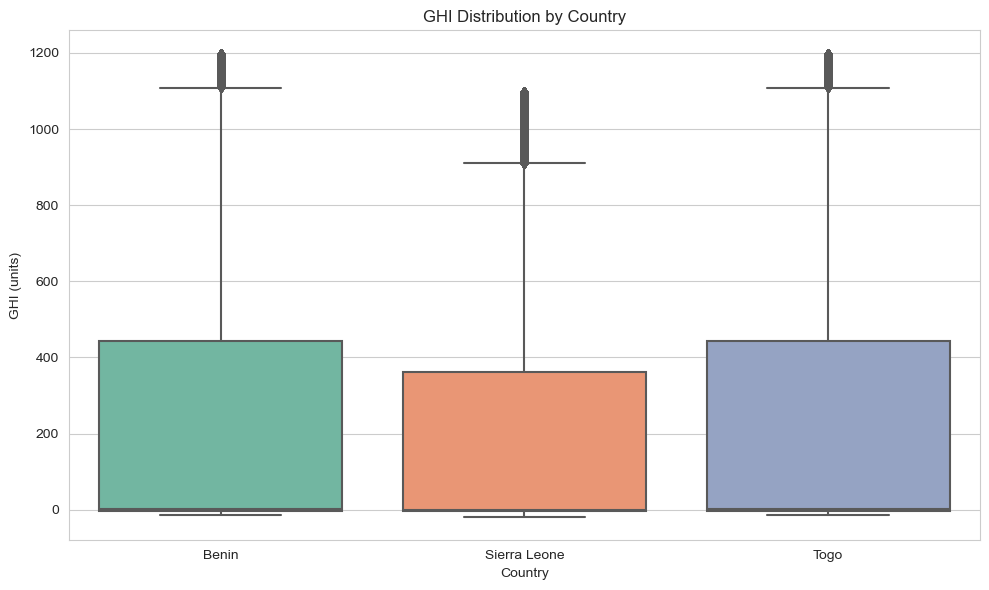

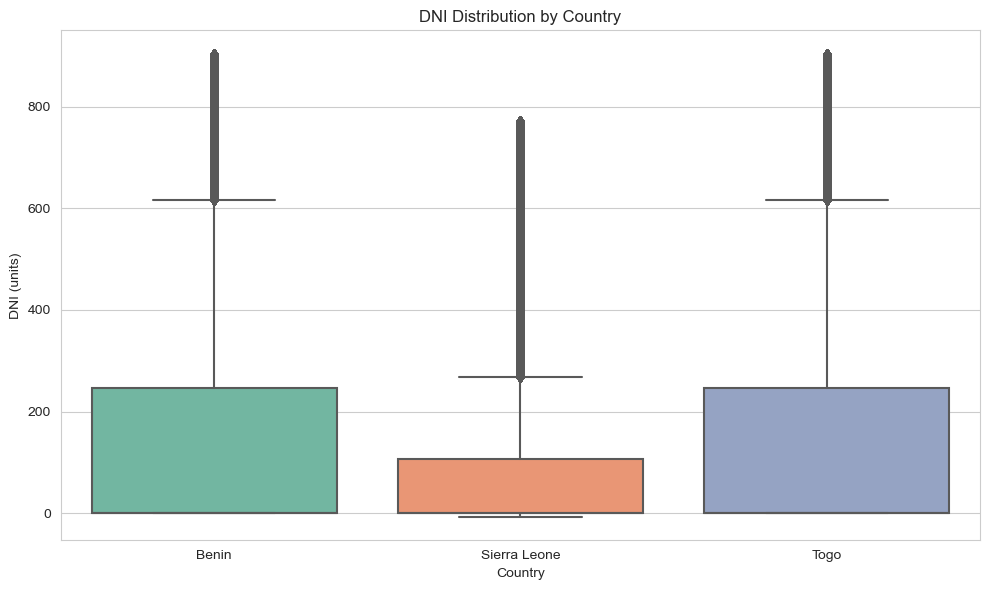

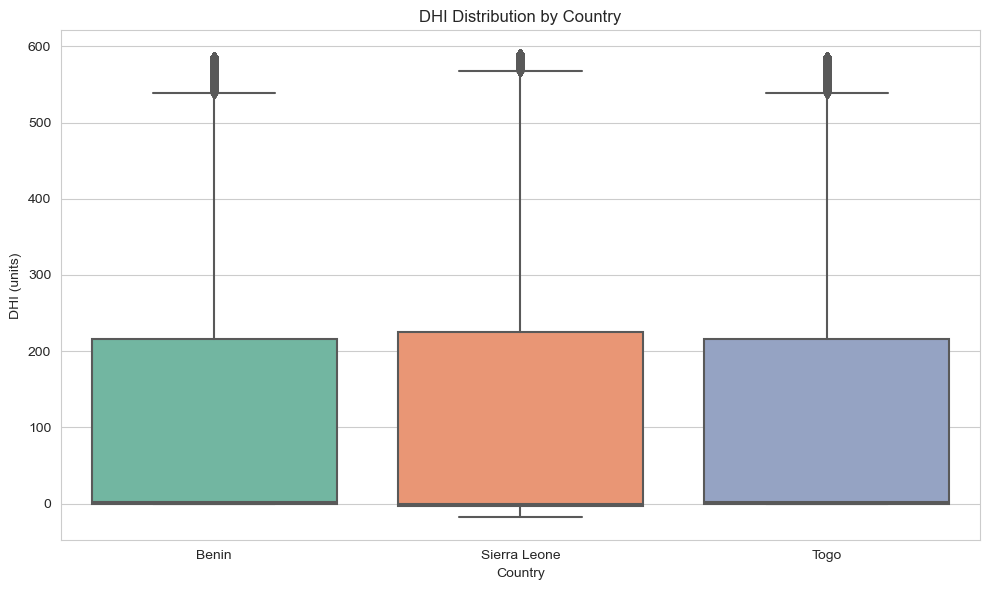

In [4]:
melted = tidy_df.melt(id_vars="Country", value_vars=METRICS, var_name="Metric", value_name="Value")

for metric in METRICS:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=melted[melted["Metric"] == metric], x="Country", y="Value", palette="Set2")
    plt.title(f"{metric} Distribution by Country")
    plt.ylabel(f"{metric} (units)")
    plt.xlabel("Country")
    plt.tight_layout()
    plt.show()



In [5]:
anova_results = {}
kruskal_results = {}

for metric in METRICS:
    samples = [df[metric].values for df in country_dfs.values()]
    anova_stat, anova_p = stats.f_oneway(*samples)
    kruskal_stat, kruskal_p = stats.kruskal(*samples)
    anova_results[metric] = {"F": anova_stat, "p_value": anova_p}
    kruskal_results[metric] = {"H": kruskal_stat, "p_value": kruskal_p}

anova_df = pd.DataFrame.from_dict(anova_results, orient="index")
kruskal_df = pd.DataFrame.from_dict(kruskal_results, orient="index")

print("One-way ANOVA results:")
display(anova_df)

print("Kruskal–Wallis results:")
display(kruskal_df)



One-way ANOVA results:


,F,p_value
GHI,1482.582198,0.000000e+00
DNI,3842.038656,0.000000e+00
DHI,53.476400,5.974234e-24


Kruskal–Wallis results:


,H,p_value
GHI,4782.264458,0.0
DNI,113823.335441,0.0
DHI,68123.892714,0.0


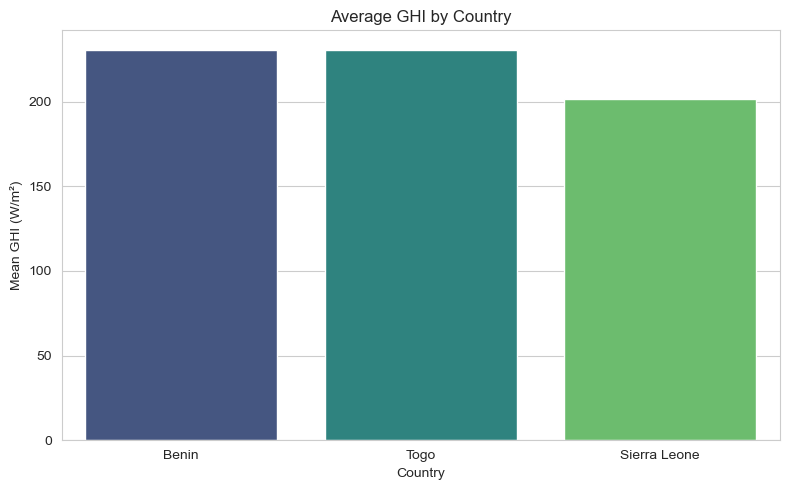

In [6]:
avg_ghi = summary_table[summary_table["Metric"] == "GHI"].sort_values("mean", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=avg_ghi, x="Country", y="mean", palette="viridis")
plt.title("Average GHI by Country")
plt.ylabel("Mean GHI (W/m²)")
plt.xlabel("Country")
plt.tight_layout()
plt.show()



In [7]:
def format_summary(df, metric):
    subset = df[df["Metric"] == metric].copy()
    subset = subset.sort_values("mean", ascending=False)
    return subset[["Country", "mean", "median", "std"]]

summary_by_metric = {metric: format_summary(summary_table, metric) for metric in METRICS}
summary_by_metric



{'GHI':         Country        mean  median         std
 2         Benin  230.525992     2.1  322.441047
 8          Togo  230.525992     2.1  322.441047
 5  Sierra Leone  201.612506     0.3  297.381491,
 'DNI':         Country        mean  median         std
 1         Benin  151.195803     0.0  250.762744
 7          Togo  151.195803     0.0  250.762744
 4  Sierra Leone  115.675784    -0.1  216.415753,
 'DHI':         Country        mean  median         std
 0         Benin  116.199911     2.5  155.737004
 6          Togo  116.199911     2.5  155.737004
 3  Sierra Leone  113.465147    -0.1  158.112828}

## Cross-Country Highlights

- Benin and Togo track each other almost perfectly across GHI, DNI, and DHI (identical means and medians in the summary table), while Sierra Leone sits roughly 30 W/m² lower on GHI/DNI medians, underscoring its comparatively weaker resource.
- Spread is also comparable for Benin and Togo (matching standard deviations), whereas Sierra Leone shows slightly tighter DHI variability with a more diffuse-heavy distribution in the boxplots.
- One-way ANOVA and Kruskal–Wallis tests both return p-values ≈ 0 for every metric, so the cross-country differences are statistically significant rather than sampling noise.

